<a href="https://colab.research.google.com/github/IANGECHUKI176/deeplearning/blob/main/pytorch/gans/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

original paper: https://arxiv.org/pdf/1511.06434.pdf

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import transforms
import numpy as np
import math
import matplotlib.pyplot as plt

from torchsummary import summary

In [6]:
batch_size = 64
lr = 0.0002
n_epochs = 200
b1 = 0.5
b2 = 0.999
channels = 1
img_size = 32
latent_dim = 100
hidden_dim = 64
display_step = 5000
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
class Generator(nn.Module):
    def __init__(self,):
        super(Generator,self).__init__()
        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128,128,kernel_size = 3,padding = 1),
            nn.BatchNorm2d(128,0.8),
            nn.LeakyReLU(0.2,inplace = True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128,64,3,stride = 1,padding = 1),
            nn.BatchNorm2d(64,0.8),
            nn.LeakyReLU(0.2,inplace = True),
            nn.Conv2d(64,channels,3,stride = 1,padding = 1),
            nn.Tanh()
        )
    def forward(self,x):
        out = self.l1(x)
        out = out.view(out.size(0),128,self.init_size,self.init_size)
        out = self.conv_blocks(out)

        return out


In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [
                nn.Conv2d(in_filters,out_filters,3,2,1),
                nn.LeakyReLU(0.2,inplace = True),
                nn.Dropout(0.25)
            ]
            if bn:
                block.append(nn.BatchNorm2d(out_filters,0.8))
            return block
        self.model = nn.Sequential(
            *discriminator_block(channels,16,bn = False),
            *discriminator_block(16,32),
            *discriminator_block(32,64),
            *discriminator_block(64,128),
        )
        ds_size = img_size // 2**4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
    def forward(self,x):
        out = self.model(x)
        out = out.view(out.size(0),-1)
        out = self.adv_layer(out)
        return out

In [9]:
def weight_init_normal(m :nn.Module):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


In [10]:
adversarial_loss = nn.BCELoss()
generator = Generator().to(device)
discriminator = Discriminator().to(device)
optimizer_G = torch.optim.Adam(generator.parameters(),lr = lr,betas=(b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(),lr = lr,betas=(b1,b2))


In [11]:
generator.apply(weight_init_normal)
discriminator.apply(weight_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (adv_layer): Sequ

In [12]:
dataloader = DataLoader(
    datasets.MNIST(
        './root',
        download = True,
        train = True,
        transform = transforms.Compose([
            transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])
        ])
    ),
    batch_size = batch_size,
    shuffle = True
)

100%|██████████| 9912422/9912422 [00:00<00:00, 359751066.42it/s]


Extracting ./root/MNIST/raw/train-images-idx3-ubyte.gz to ./root/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 41742141.22it/s]

Extracting ./root/MNIST/raw/train-labels-idx1-ubyte.gz to ./root/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 166716278.88it/s]


Extracting ./root/MNIST/raw/t10k-images-idx3-ubyte.gz to ./root/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 25813724.62it/s]

Extracting ./root/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./root/MNIST/raw



In [13]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

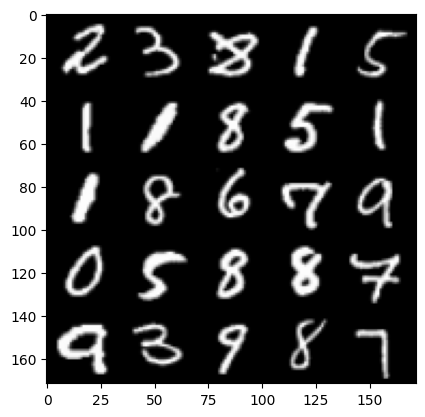

In [14]:
images,labels = next(iter(dataloader))
show_tensor_images(images)

In [15]:
from tqdm.auto import tqdm

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5, step 5000: Generator loss: 0.7951804762125003, discriminator loss: 0.6454485159814357


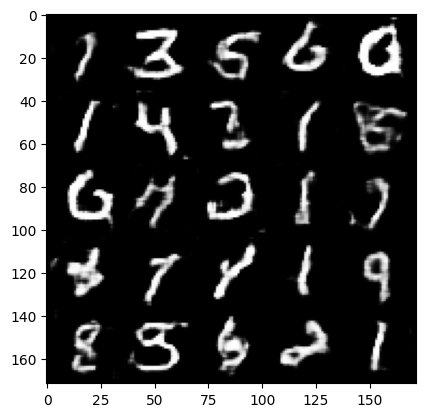

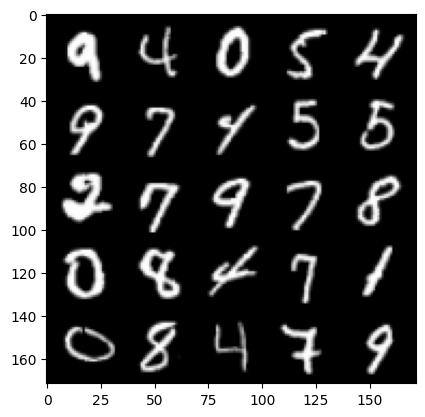

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10, step 10000: Generator loss: 0.9205622008085252, discriminator loss: 0.5911797512173678


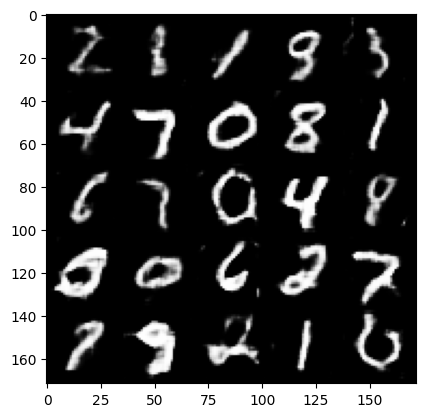

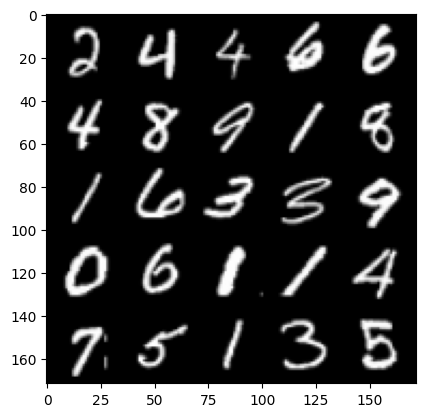

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 15, step 15000: Generator loss: 0.9899003852486589, discriminator loss: 0.5645736922800528


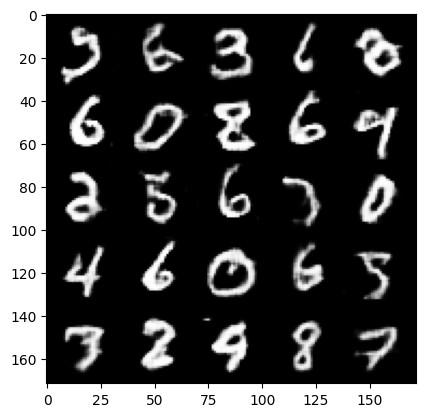

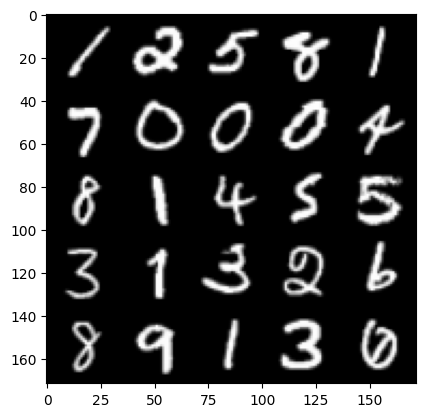

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 21, step 20000: Generator loss: 1.0421187099456795, discriminator loss: 0.5523180778890836


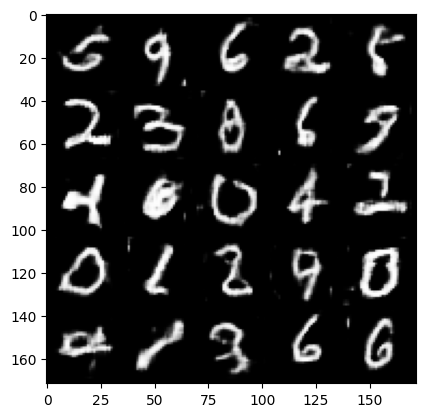

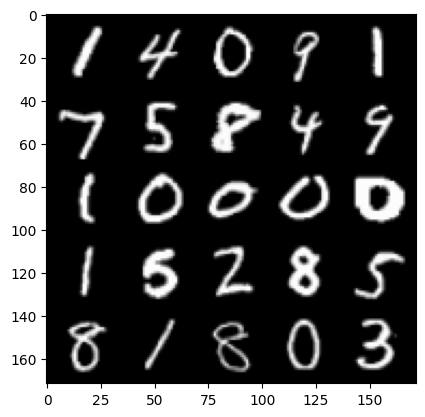

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 26, step 25000: Generator loss: 1.094863324707743, discriminator loss: 0.5383525029450666


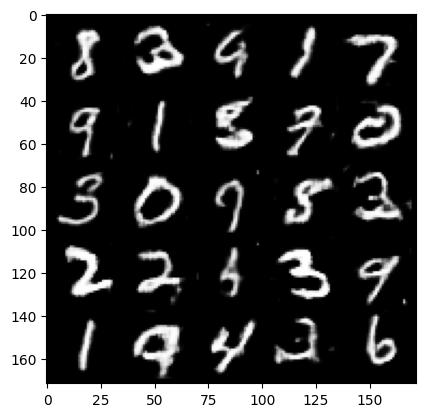

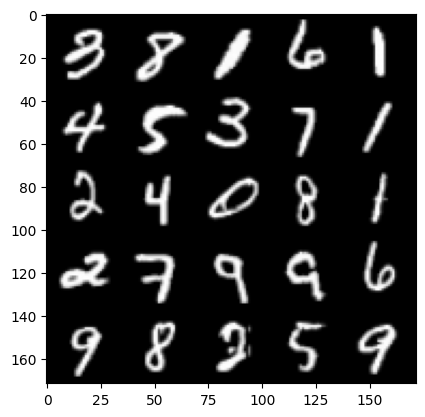

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 31, step 30000: Generator loss: 1.1505990485072148, discriminator loss: 0.5192112268388254


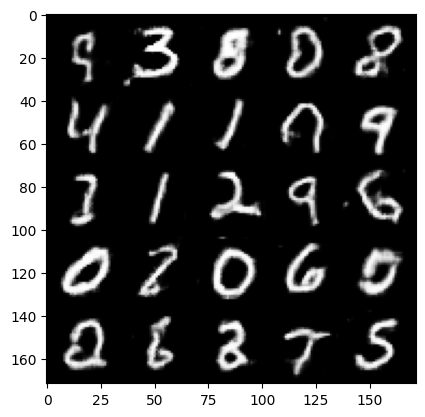

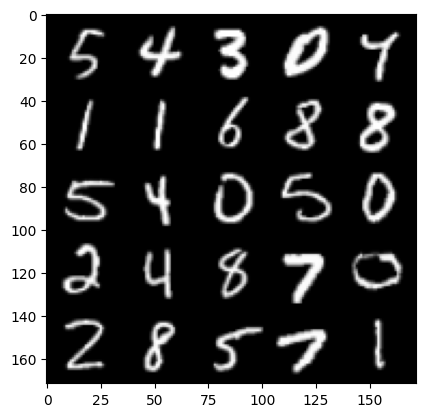

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 37, step 35000: Generator loss: 1.2274584787830711, discriminator loss: 0.49921962238252365


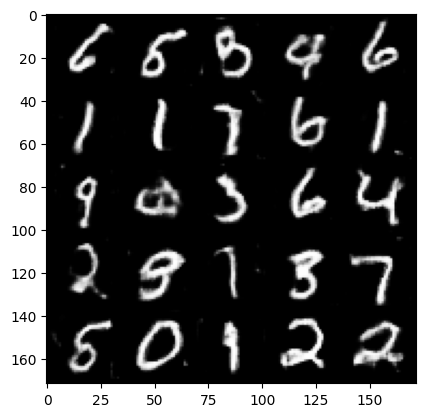

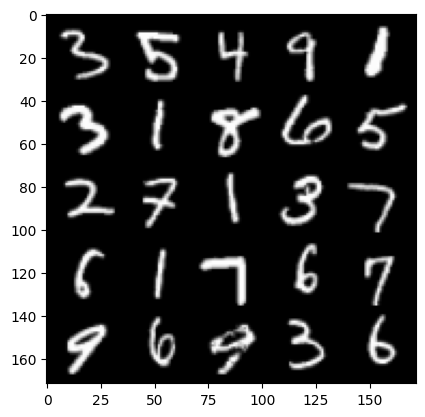

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 42, step 40000: Generator loss: 1.29255758045912, discriminator loss: 0.48261666368395056


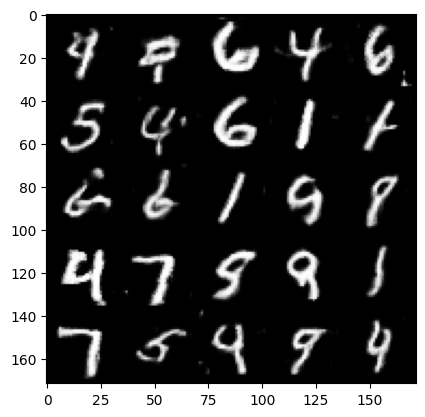

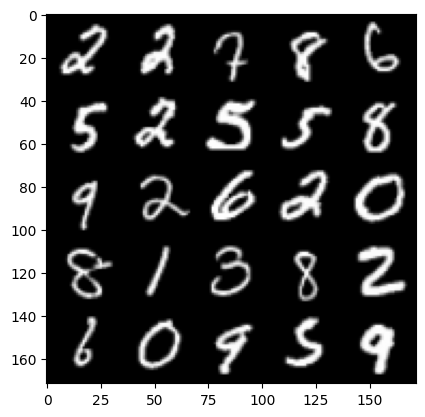

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 47, step 45000: Generator loss: 1.344010943269732, discriminator loss: 0.4693393170893195


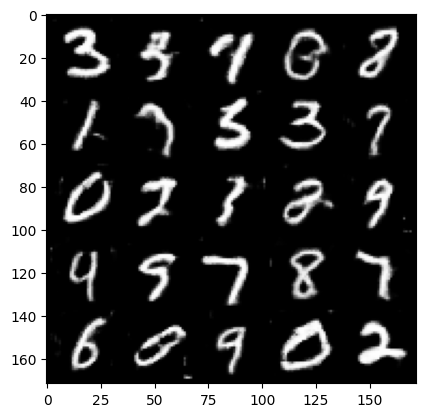

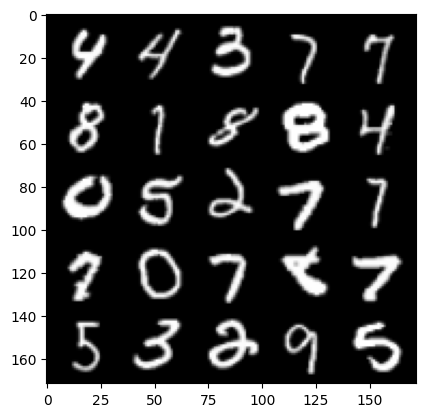

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 53, step 50000: Generator loss: 1.4235659358918646, discriminator loss: 0.45867617779225056


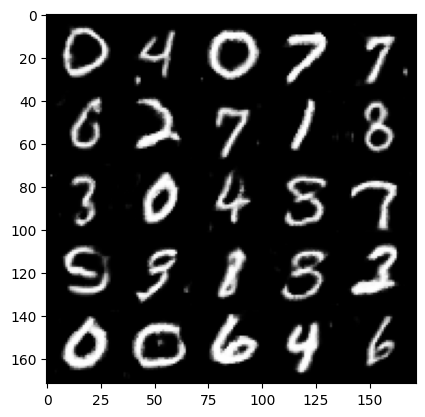

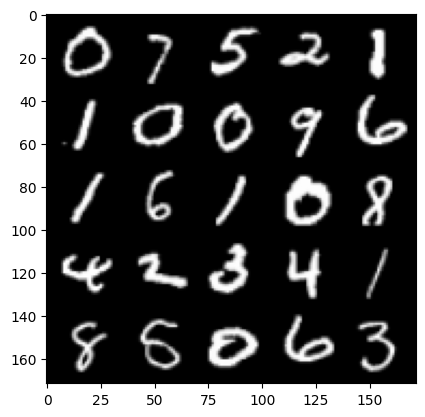

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 58, step 55000: Generator loss: 1.4826522357046608, discriminator loss: 0.44769050237089364


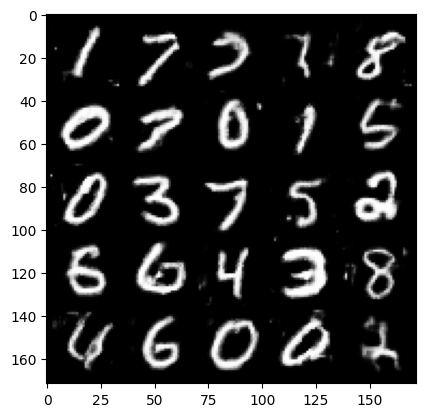

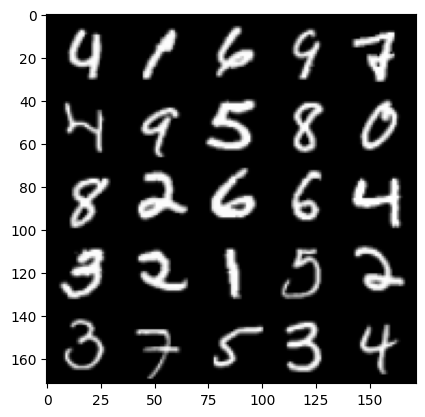

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 63, step 60000: Generator loss: 1.5624614268437063, discriminator loss: 0.42368654969185665


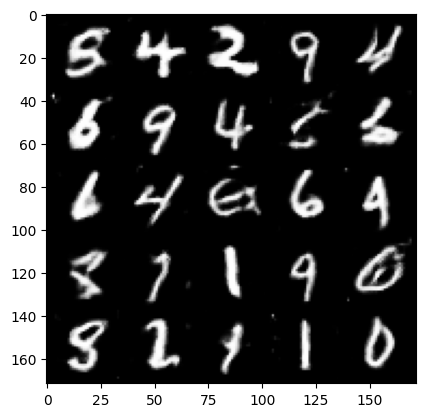

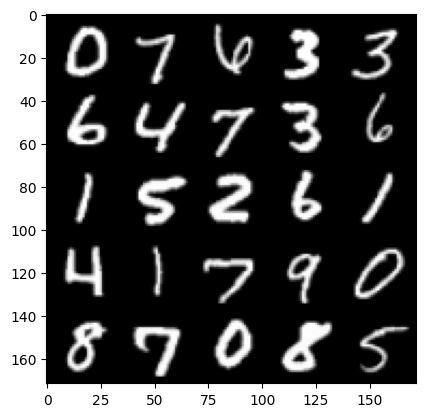

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 69, step 65000: Generator loss: 1.6298441900908893, discriminator loss: 0.413915774252266


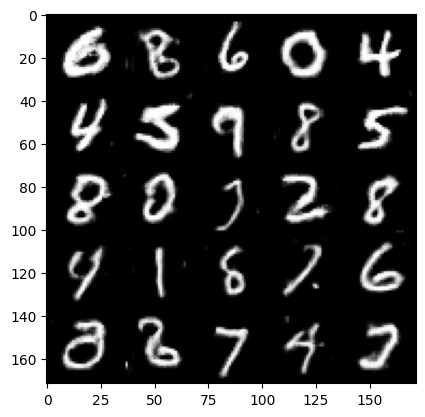

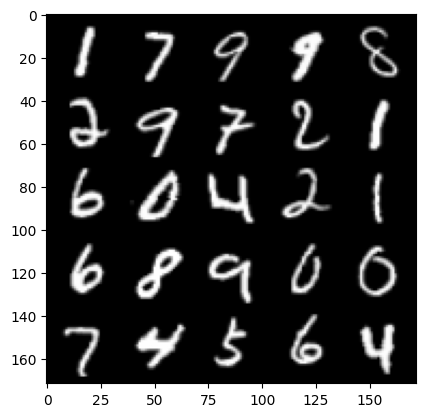

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 74, step 70000: Generator loss: 1.7459291560500905, discriminator loss: 0.3962043171592071


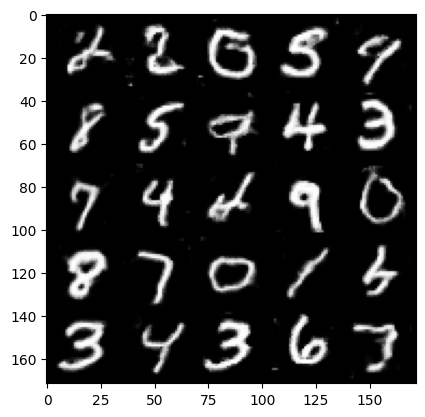

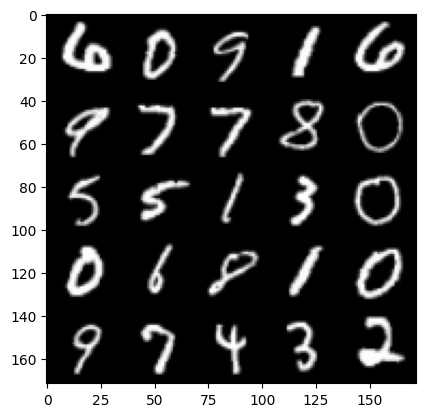

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 79, step 75000: Generator loss: 1.8346255195930563, discriminator loss: 0.37698802801892295


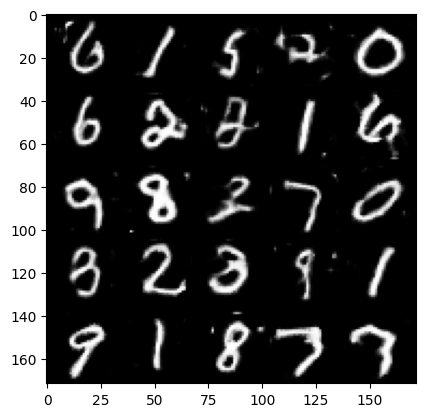

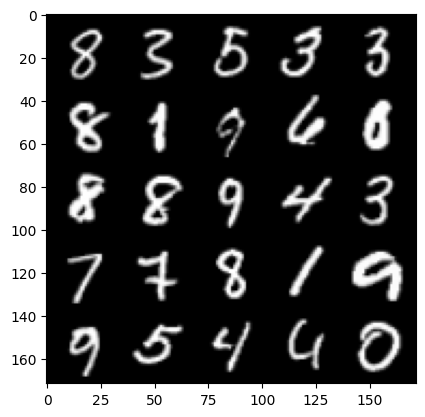

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 85, step 80000: Generator loss: 2.004510277616236, discriminator loss: 0.3443383926425134


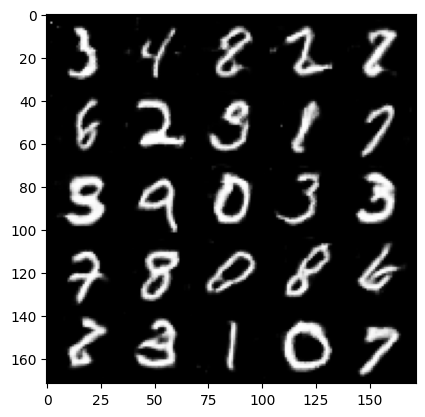

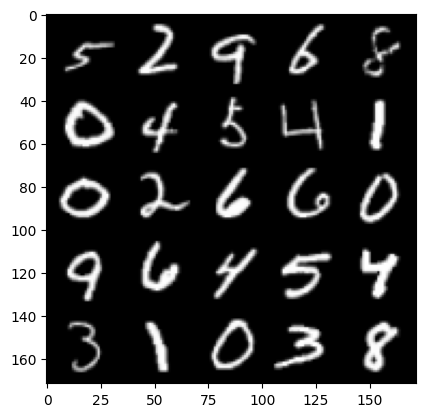

In [ ]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    for imgs,labels in tqdm(dataloader):
        real_imgs = imgs.to(device)

        # Adversarial ground truths
        valid = torch.ones(real_imgs.size(0),1).to(device)
        fake  = torch.zeros(real_imgs.size(0),1).to(device)

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.normal(0,1,(real_imgs.size(0),latent_dim)).to(device)

        # Generate a batch of images
        generated_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(generated_imgs),valid)

        g_loss.backward()

        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        real_loss = adversarial_loss(discriminator(real_imgs),valid)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()),fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # Keep track of the average discriminator loss
        mean_discriminator_loss += d_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += g_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")

            show_tensor_images(generated_imgs)
            show_tensor_images(real_imgs)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1